In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Task C 
### With so few datapoints we run into problems to compute the parameters of the gaussian distribution. When we run into problems, we don't (and cannot) plot the curves. 
### This can be explained as follows. If we take a look at the formulas on p. 30 top and especially $\mu_c^{new} = \frac{\sum_n r_c^{(n)}x^{(n)}}{\sum_n r_c^{(n)}}$ and $(\sigma_c^{new})^2=\frac{\sum_n r_c^{(n)}(x^{(n)}-\mu_c^{new})^2}{\sum_n r_c^{(n)}}$ 
### After some Debugging we found, that some $\sigma_c$ are 0 and this results in a problem because $\sigma$ is in the gaussian distribution in the denominator of the exponential term. Thus, we would devide by 0. 
### The question is: Why do we have $sigma_c$ = 0? According to the formulas this happens if $r_c^{(n)}$ is 0 or $x^{(n)}-\mu_c^{new}$ is 0 for all c. 
### 1. Take a look at the formula of $r_c^{(n)}$. If the x_i value is too far away from the intial gaussian guess, the nominator gets 0 and therefore $r_c^{(n)}$ is 0. This happens because our 5 datapoints are randomly generated. It can happen, that these datapoints are far far away from the intial guess and the exponential function yields very small numbers (~1e-30). 
### 2. This gets problematic if we compute $\mu_c^{(n)}$. Assume only 4 out of 5 datapoints yields to very small $r_c^{(n)}$. Then the summation "picks out" only one $x^{(n)}$ namely $x_i$ . So $\mu_c^{(new)} \approx x_j$
### 3. In the formula for $(\sigma_c^{(new)})^2$ we take the difference of $\mu_c^{(new)} and the $x^{(n)} vector and get approximately $\sigma_c^{(new)} \approx 0$. The other terms are approximately also 0 because $r_c^{(n)}$ is nearly 0. And now we divide by 0 (in one of the next iterations if sigma gets even smaller) in the exponential function.

### In summary: If we have few datapoints and many of them lie far away from the initial gaussian guess. The $\mu_c^{(new)}$ and $r_c^{(n)}$ just get the right value that $\sigma_c^{(new)}$ is 0.

In [2]:
def gaussian_pdf(x, mu, sigma):

    """
    Calculate gaussian probability density for x with mean mu and standard deviation sigma.
    """

    pdf = ((1 / np.sqrt(2 * np.pi * sigma **2)) * 
           np.exp(-1 / sigma ** 2 * (x - mu) ** 2))
    
    return pdf


class EMAlgorithm:

    """
    Class that implements the EM algorithm. This can be applied for gaussian mixture models that consists 
    of K different gaussians.

    parameters:
    
    sample_func: Function to sample the data (generative model)
    N: Number of data points
    K_gaussians: Number of mixture components
    initial_mu: Initial mean value
    initial_sigma: Initial value for the standard deviation
    conv_thr: Convergence threshold for the log-likelyhood
    max_steps: maximum number of iterations


    """
    
    def __init__(self, sample_func, N, K_gaussians, initial_mu=0.0,
                 initial_sigma=6.0, conv_thr=0.000001, max_steps=100):
        
        self.K_gaussians = K_gaussians
        self.x = sample_func(N)
        self.sigma = [initial_sigma] * self.K_gaussians
        self.mu = [initial_mu] * self.K_gaussians
        self.N= N
        self.r = None
        self.conv_thr = conv_thr
        self.max_steps = max_steps
        self.pi = np.random.uniform(size=self.K_gaussians) 
        self.pi /= self.pi.sum()

    def _calc_r_denomin(self):

        """
        Calculate denominator for the update rule of r.
        """

        nom = np.array([(1 / np.sqrt(2 * np.pi * self.sigma[i] ** 2) *
                        np.exp(-1 / (2 * self.sigma[i] ** 2) * 
                        (self.x - self.mu[i]) ** 2)) * self.pi[i] for i 
                        in range(self.K_gaussians)]).sum(axis=0)
            
        return nom

    def _expectation_step(self):
        
        """
        Performs one expectation step.
        """

        denominator = self._calc_r_denomin()

        self.r = [((1 / np.sqrt(2 * np.pi * self.sigma[i] ** 2) *
                   np.exp(-1 / (2 * self.sigma[i] ** 2) * 
                    (self.x - self.mu[i]) ** 2)) * self.pi[i] / denominator
                     
                
                 ) for i in range(self.K_gaussians)]
    
    def _maximization_step(self):
        
        """
        Performs one maximization step.
        """

        self.pi = [1 / self.N * self.r[i].sum() for i in range(self.K_gaussians)]
        self.mu = [(self.x * self.r[i]).sum() / self.r[i].sum() for i in range(self.K_gaussians)]
        self.sigma = np.sqrt([(((self.x - self.mu[i]) ** 2) * self.r[i]).sum() / self.r[i].sum() 
                                for i in range(self.K_gaussians)])
    
    def _calculate_gaussian_mixture(self):

        """
        Calculate the probability given by a gaussian mixture.
        """

        p = np.array([self.pi[i] * gaussian_pdf(self.x, self.mu[i], self.sigma[i]) 
                      for i in range(self.K_gaussians)]).sum(axis=0)

        return p

    def _calculate_log_likelyhood(self):

        """
        Calculate the log-likelyhood.        
        """

        p = self._calculate_gaussian_mixture()
        log_likelyhood = np.log(p).sum()
        
        return log_likelyhood
    
    def run(self, print_=True, return_=True, conv=False):

        """
        Run the EM algorithm.

        parameters:

        print_: Whether to print the log-likelyhood in each step
        return_: Whether to return the list of log-likelyhoods
        conv: Whether to consider the convergence of the log-likelyhood to stop the iterations. If False,
              only the maximum number of steps is considered.
        """
        
        converged = False
        step = 0
        log_likelyhood = self._calculate_log_likelyhood()
        log_likelyhood_list = [log_likelyhood]
        
        if print_:
                print(f"step {step}: {log_likelyhood}")
        
        while not converged and step < self.max_steps:
            
            self._expectation_step()
            self._maximization_step()
            
            prev_log_likelyhood = log_likelyhood
            log_likelyhood = self._calculate_log_likelyhood()
            log_likelyhood_list.append(log_likelyhood)
            step += 1
            
            if print_:
                print(f"step {step}: {log_likelyhood}")
            
            if np.abs(log_likelyhood - prev_log_likelyhood) < self.conv_thr and conv:
                converged = True

        if return_:
            return log_likelyhood_list
    
    def return_final_parameters(self):

        """
        Return the final parameters for the gaussian mixture.
        """
        
        return {"pi": self.pi, "mu": self.mu, "sigma": self.sigma}

In [3]:
# Sample data from gaussian distribution with mean 20 and standard deviation 2
def gen_samples(N): return np.random.normal(loc=20, scale=2, size=N)

def gen_samples_2(N, parameters):

    """
    Generates data from a gaussian mixture with two components.
    """

    randoms = np.random.uniform(size=N)

    mixture = np.array([np.random.normal(loc=20, scale=2, size=1) if r < 0.25 
                        else np.random.normal(loc=10, scale=1, size=1) for r in randoms])

    return mixture.flatten()

In [4]:
# EM algorithm for 100 samples
EM = EMAlgorithm(sample_func=gen_samples, N=100, K_gaussians=1, max_steps=40)

# Task A

In [5]:
sample = EM.x

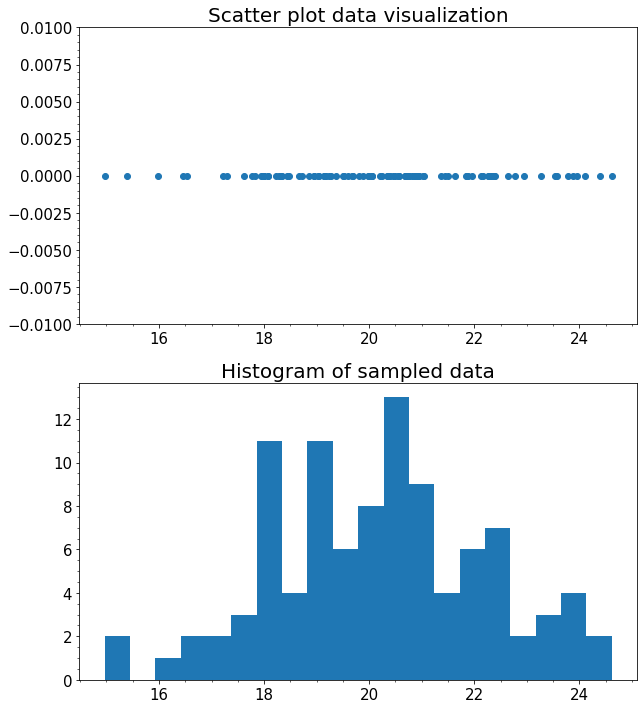

In [6]:
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

fig, ax = plt.subplots(nrows=2, figsize=(10, 12))

ax[0].scatter(sample, [0] * sample.shape[0])
ax[0].set(ylim=(-0.01, 0.01))
ax[0].set_title("Scatter plot data visualization", fontsize=20)
ax[0].minorticks_on()

ax[1].set_title("Histogram of sampled data", fontsize=20)
_ = ax[1].hist(sample, bins=20)
ax[1].minorticks_on()


# Task B + C

In [7]:
# In the case of one gaussian, convergence is directly achieved
iterations = EM.run()

step 0: -1414.586760736636
step 1: -262.3957323328046
step 2: -262.3957323328046
step 3: -262.3957323328046
step 4: -262.3957323328046
step 5: -262.3957323328046
step 6: -262.3957323328046
step 7: -262.3957323328046
step 8: -262.3957323328046
step 9: -262.3957323328046
step 10: -262.3957323328046
step 11: -262.3957323328046
step 12: -262.3957323328046
step 13: -262.3957323328046
step 14: -262.3957323328046
step 15: -262.3957323328046
step 16: -262.3957323328046
step 17: -262.3957323328046
step 18: -262.3957323328046
step 19: -262.3957323328046
step 20: -262.3957323328046
step 21: -262.3957323328046
step 22: -262.3957323328046
step 23: -262.3957323328046
step 24: -262.3957323328046
step 25: -262.3957323328046
step 26: -262.3957323328046
step 27: -262.3957323328046
step 28: -262.3957323328046
step 29: -262.3957323328046
step 30: -262.3957323328046
step 31: -262.3957323328046
step 32: -262.3957323328046
step 33: -262.3957323328046
step 34: -262.3957323328046
step 35: -262.3957323328046
st

In [8]:
# final parameters
final_parameters = EM.return_final_parameters()

print("The final parameters are:")
print("mean value: {}\nstandard deviation: {}\npi: {}".format(
      final_parameters["mu"], final_parameters["sigma"], final_parameters["pi"])
      )
     

The final parameters are:
mean value: [20.1883628965707]
standard deviation: [2.02388471]
pi: [1.0]


* The result shows that the values are not fully recovered. This is due to the small number of samples and the accuracy will be increased by a larger number of samples, as shown in the next steps. Furthermore, in the case of small sample numbers, the fluctuation of the results for different runs is larger.

# Task D
* Run EM algorithm for different sample sizes

In [9]:
final_parameters = []
results = []

for n_samples in [3, 5, 10, 50, 70, 100, 150, 250, 500, 1000, 5000, 10000, 50000, 100000]:
    EM = EMAlgorithm(sample_func=gen_samples, N=n_samples, K_gaussians=1)
    EM.run(print_=False, return_=False)
    final_parameter = EM.return_final_parameters()

    parameter_str = "{} samples:\nmean value: {}\nstandard deviation: {}\npi: {}\n".format(
                    n_samples, final_parameter["mu"], final_parameter["sigma"], final_parameter["pi"]
                    )
    final_parameters.append(parameter_str)
    results.append({"n_samples": n_samples, "mean": final_parameter["mu"][0], 
                    "std": final_parameter["sigma"][0]})
            

print("The final parameters are:")
print("\n".join(final_parameters))

The final parameters are:
3 samples:
mean value: [19.22083984078384]
standard deviation: [0.96876818]
pi: [1.0]

5 samples:
mean value: [20.041145930174878]
standard deviation: [1.52870194]
pi: [1.0]

10 samples:
mean value: [19.58582977478905]
standard deviation: [1.38290401]
pi: [1.0]

50 samples:
mean value: [19.76584736504703]
standard deviation: [1.92005123]
pi: [1.0]

70 samples:
mean value: [19.937953173727557]
standard deviation: [1.84010714]
pi: [1.0]

100 samples:
mean value: [20.012315326364345]
standard deviation: [1.83949257]
pi: [1.0]

150 samples:
mean value: [19.94481704976278]
standard deviation: [2.01994446]
pi: [1.0]

250 samples:
mean value: [19.961745533015357]
standard deviation: [2.01971111]
pi: [1.0]

500 samples:
mean value: [20.1238156738666]
standard deviation: [2.01876327]
pi: [1.0]

1000 samples:
mean value: [19.956347114686636]
standard deviation: [1.94427]
pi: [1.0]

5000 samples:
mean value: [20.006105109861767]
standard deviation: [1.9867224]
pi: [1.0]


In [10]:
df_results = pd.DataFrame(results)
df_results = df_results.set_index("n_samples")
df_results

,mean,std
n_samples,,
3,19.220840,0.968768
5,20.041146,1.528702
10,19.585830,1.382904
50,19.765847,1.920051
70,19.937953,1.840107
100,20.012315,1.839493
150,19.944817,2.019944
250,19.961746,2.019711
500,20.123816,2.018763


The accuracy increases with an increasing sample number. In the last steps, the deviation is only at the 3rd decimal digit. For small sample numbers, the deviation is quite large but still in a proper region around the exact values.